In [3]:
from __future__ import print_function
import os
import numpy as np
from sequence_for_nn import *
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import random
from reading import *

path = "../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis"

found file ../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis/counters.pyob


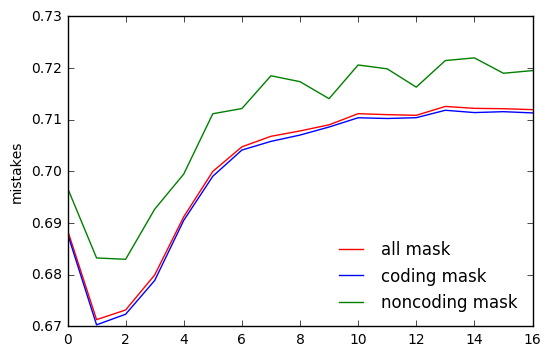

In [4]:
plot_mistakes(path)

In [179]:
seq_np = get_seq_np(path)
mask = get_mask(path)
seq_np.shape

(4, 500000)

In [9]:
b = baseline(path, n = 2)

0  1  

In [6]:
b

{'baseline_mean': 376401.5,
 'baseline_part': 0.83190741199144225,
 'baseline_part_sd': 0.00090948070088583196,
 'baseline_sd': 411.5}

In [8]:
baseline_codons(path)

100000  200000  300000  400000  

0.72488269208198497

found file ../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis/diffs.npy
found file ../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis/counters.pyob
found file ../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis/props.pyob


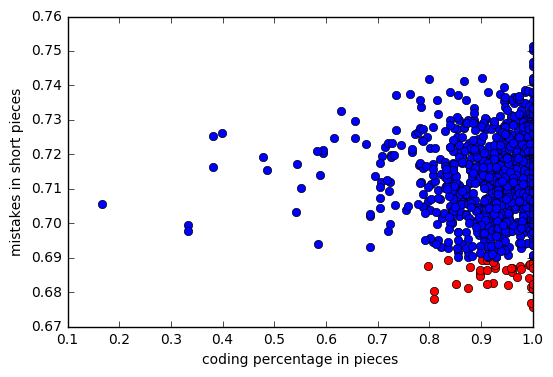

found file ../results/04-01-17-36_0.0-11.3_Mycobacterium_tuberculosis/props.pyob


In [185]:
proteins = get_proteins(path, get_good_parts(path, 0.69))

In [186]:
loss = get_loss(path)

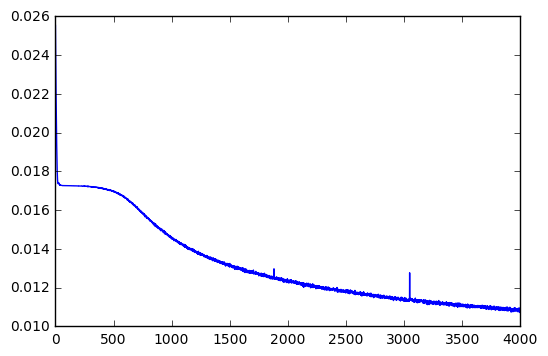

In [187]:
fig, ax = plt.subplots()
ax.plot(loss)
plt.show()

In [188]:
path1 = "../results/03-27-20-59_0.0-12.7_myco_cds_mycobac"
info = open(path1 + "/info.txt")
for line in info.readlines():
    print(line, end = "")
info.close()

03-27-20-59
0500000_000000000_0.0-12.7_47573_myco_cds_mycobac_coding_seqs_concateneted
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4000,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4000,True,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU


In [189]:
diff = get_diff(path1)
counters = get_counters(path1)

found file ../results/03-27-20-59_0.0-12.7_myco_cds_mycobac/diffs.npy
found file ../results/03-27-20-59_0.0-12.7_myco_cds_mycobac/counters.pyob


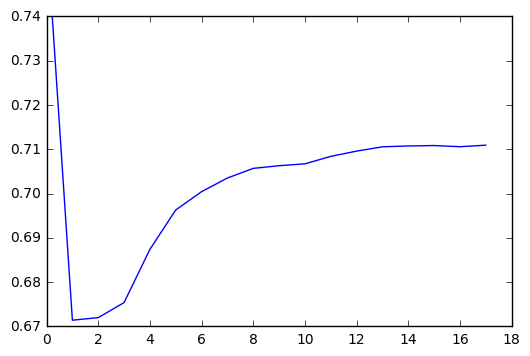

In [190]:
fig, ax = plt.subplots()
ax.plot([counter['mask_part'] for counter in counters], "b")
plt.ylim(0.67, 0.74)
plt.show()

In [191]:
path2 = "../results/04-01-22-06_0.0-100.0_myco_non_mycobac"
info = open(path2 + "/info.txt")
for line in info.readlines():
    print(line, end = "")
info.close()

04-01-22-06
0464341_000000000_0.0-100.0_44197_myco_non_mycobac_non_coding_regions_concateneted
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU


In [192]:
diff = get_diff(path2)
counters = get_counters(path2)

found file ../results/04-01-22-06_0.0-100.0_myco_non_mycobac/diffs.npy
found file ../results/04-01-22-06_0.0-100.0_myco_non_mycobac/counters.pyob


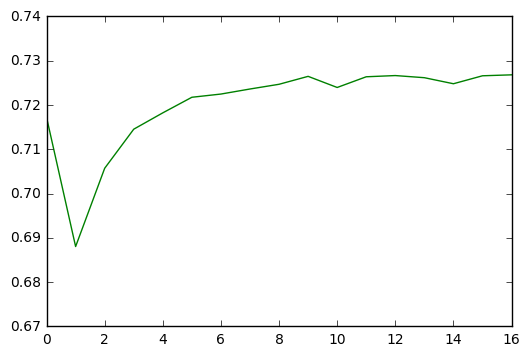

In [193]:
fig, ax = plt.subplots()
ax.plot([counter['mask_part'] for counter in counters], "g")
plt.ylim(0.67, 0.74)
plt.show()

In [194]:
path3 = "../results/04-02-10-45_0.0-22.7_Mycobacterium_tuberculosis"
info = open(path3 + "/info.txt")
for line in info.readlines():
    print(line, end = "")
info.close()

04-02-10-45
1000000_000000000_0.0-22.7_95188_Mycobacterium_tuberculosis_H37Rv,_complete_genome
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
1678.554s	GeForce GTX TITAN X


found file ../results/04-02-10-45_0.0-22.7_Mycobacterium_tuberculosis/diffs.npy
found file ../results/04-02-10-45_0.0-22.7_Mycobacterium_tuberculosis/counters.pyob
found file ../results/04-02-10-45_0.0-22.7_Mycobacterium_tuberculosis/props.pyob


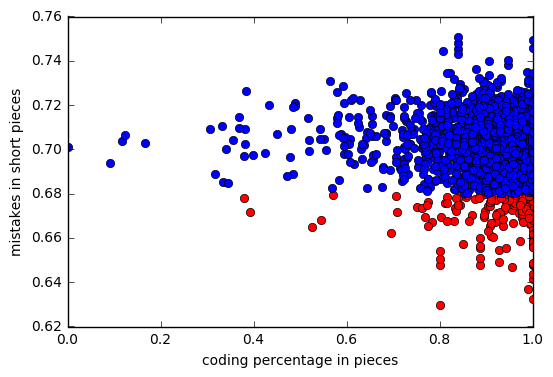

found file ../results/04-02-10-45_0.0-22.7_Mycobacterium_tuberculosis/props.pyob


In [195]:
proteins3 = get_proteins(path3, get_good_parts(path3, 0.68))

In [196]:
print(len(set(proteins)))
print(len(set(proteins3)))
print(len(set(proteins) & set(proteins3)))
print(len(set(proteins) | set(proteins3)))

21
75
10
86


In [197]:
path4 = "../results/04-02-18-22_0.0-11.3_Mycobacterium_tuberculosis"
info = open(path4 + "/info.txt")
for line in info.readlines():
    print(line, end = "")
info.close()

04-02-18-22
0500000_000000000_0.0-11.3_47573_Mycobacterium_tuberculosis_H37Rv,_complete_genome
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
911.728s	GeForce GTX TITAN X


found file ../results/04-02-18-22_0.0-11.3_Mycobacterium_tuberculosis/diffs.npy
found file ../results/04-02-18-22_0.0-11.3_Mycobacterium_tuberculosis/counters.pyob
found file ../results/04-02-18-22_0.0-11.3_Mycobacterium_tuberculosis/props.pyob


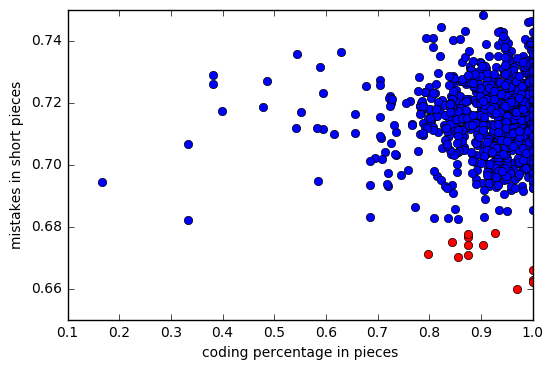

found file ../results/04-02-18-22_0.0-11.3_Mycobacterium_tuberculosis/props.pyob


In [201]:
proteins4 = get_proteins(path4, get_good_parts(path4, 0.68))

In [202]:
print(len(set(proteins)), len(set(proteins4)))
print(len(set(proteins) & set(proteins4)))
print(len(set(proteins) | set(proteins4)))

21 4
1
24


In [1]:
path5 = "../results/04-03-17-32_11.3-22.7_Mycobacterium_tuberculosis"
# proteins5 = get_proteins(path5, get_good_parts(path5, 0.7))

found file ../results/04-03-17-32_11.3-22.7_Mycobacterium_tuberculosis/counters.pyob


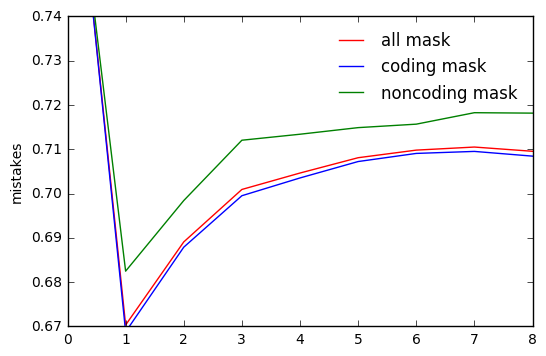

In [7]:
plot_mistakes(path5)

In [2]:
from reading import *
from sequence_for_nn import *
baseline(path5, n = 2)

0  1  

{'baseline_mean': 374985.0,
 'baseline_part': 0.8288518285202745,
 'baseline_part_sd': 0.00065868726722146699,
 'baseline_sd': 298.0}

calculating ../results/04-03-19-31_22.7-34.0_Mycobacterium_tuberculosis/diffs.npy
0 1 2 3 4 5 6 7 8 0   1   2   3   4   5   6   7   8   

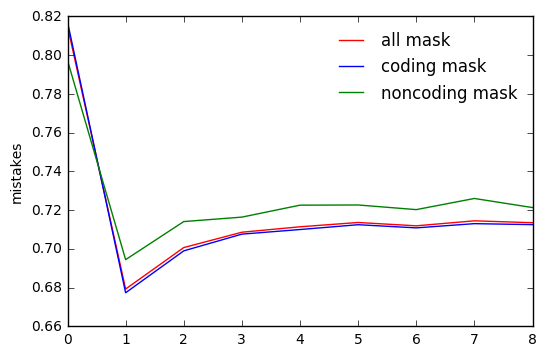

In [7]:
path6 = "../results/04-03-19-31_22.7-34.0_Mycobacterium_tuberculosis"
plot_mistakes(path6)

In [171]:
# container = Container()
# container.read_seq("../data/myco.genbank", "genbank")
# container.start = 0
# container.length = 1000000
# properties = {"start": container.start,
#              "length": container.length,
#              "record": container.record}
# with open(os.path.join(path3, "props.pyob"), "wb") as file:
#     pickle.dump(properties, file)

container created
read seq from file ../data/myco.genbank, length = 4411532


Про консервативность

In [ ]:
import pyBigWig
import numpy as np

In [ ]:
#файл с треком генома человека сборка 38
track_file = "/Users/pochtalionizm/Projects/neuro/data/hg38.phastCons20way.bw"

In [ ]:
bw = pyBigWig.open(track_file)
bw.chroms()
bw.chroms("chr2")

In [ ]:
#выбор нужной части трека 
track_part = bw.values("chr2", 6000000, 6500000, numpy = True)
len(track_part)

In [ ]:
print("seq length", len(diff))
print("mistakes", sum([1 for x in diff if x > 0.01]))

In [ ]:
#выбираем часть под маской
mask_diff = []
mask_track_part = []
free_diff = []
free_track_part = []
for i in range(len(diff)):
    if not (isinstance(diff[i], float) or isinstance(track_part[i], float)):
        print("None")
        
    if mask[i]==1:
        mask_diff.append(diff[i])
        mask_track_part.append(track_part[i])
    else:
        free_diff.append(diff[i])
        free_track_part.append(track_part[i])

print(len(mask_diff) + len(free_diff))
print(len(free_track_part) + len(mask_track_part))

In [ ]:
max(free_diff)

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(free_diff, free_track_part, "r,")
plt.hist2d(free_diff, free_track_part, bins = [[0, 0.1, 1.3, max(free_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on train ")
# plt.xlabel("distance")
# plt.ylabel("value of conservation")
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_1.png")

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(mask_diff, mask_track_part, "r,")
plt.hist2d(mask_diff, mask_track_part, bins = [[0, 0.1, 1.3, max(mask_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on test ")
plt.xlabel("distance")
plt.ylabel("value of conservation")
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_2.png")

In [ ]:
track_mask_for_small_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-0.0<0.1 ]
track_mask_for_big_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-1.4<0.1 ]
print(len(track_mask_for_small_d ))
print(len(track_mask_for_big_d))
plt.hist([track_mask_for_small_d , track_mask_for_big_d ], color = ['green', 'blue'], density = True)
plt.title("")
plt.show()

In [ ]:
track_free_for_small_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-0.0<0.1 ]
track_free_for_big_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-1.4<0.1 ]
print(len(track_free_for_small_d))
print(len(track_free_for_big_d))
plt.hist([track_free_for_small_d, track_free_for_big_d, track_part], color = ['green', 'blue', "red"], density = True)
plt.show()

In [ ]:
from matplotlib.patches import Rectangle
c = ['g', 'b', 'r', 'y' , 'pink']
plt.hist([track_free_for_small_d, track_free_for_big_d, track_mask_for_small_d, 
          track_mask_for_big_d, track_part], 
         color = c, density = True)

handles = [Rectangle((0,0),1,1,color=col,ec="k") for col in c]
labels= ['train0','train1','test0', 'test1', 'all' ]
plt.legend(handles, labels)
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/all_cons.png")

In [ ]:
def plot_loss(path, save = False):
    loss = np.load(path + "/loss.npy")
    fig = plt.plot(loss)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.tight_layout()
#     if save:
#         plt.savefig("pics/loss_{}.png".format(self.file_title))
    plt.show()

In [ ]:
plot_loss(path)